In [79]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification ,AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split

### Q1

In this section I will load the dataset and I will build a fucnction that read the JSON files then convert them into dataframes and save them in CSV files. We will start by exploring the dataset to understand its structure and contents. The train, test, and validation sets are then loaded into separate DataFrames.

In [89]:
def convert_json_to_dataframe(json_file, csv_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    texts = []
    hypotheses = []
    labels = []
    evidence_spans = []

    for document in data['documents']:
        annotation_set = document['annotation_sets'][0]['annotations']
        for label, annotation in annotation_set.items():
            if annotation['choice'] in {'Entailment', 'Contradiction', 'NotMentioned'}:
                texts.append(document['text'])
                hypotheses.append(data['labels'][label]['hypothesis'])
                labels.append(annotation['choice'])
                evidence_spans.append(annotation['spans'])

    data_dict = {
        'text': texts,
        'hypothesis': hypotheses,
        'label': labels,
        'evidence_spans': evidence_spans
    }

    df = pd.DataFrame(data_dict)

    df.to_csv(csv_file, index=False)

    return df

# Convert JSON to DataFrame and CSV
train_df = convert_json_to_dataframe('train.json', 'train.csv')
test_df = convert_json_to_dataframe('test.json', 'test.csv')
val_df = convert_json_to_dataframe('dev.json', 'val.csv')

In [59]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(7191, 4)
(2091, 4)
(1037, 4)


> ### Prepare Train/Test/Validation Sets from the JSON dataset:

* Data Loading: The function convert_json_to_dataframe reads the JSON files for train, test, and validation sets using the provided file paths.

* Data Extraction: The function extracts relevant information from the JSON data. For each document in the dataset, it looks at the annotation sets and selects annotations with choices that are either 'Entailment', 'Contradiction', or 'NotMentioned', as these are the relevant labels for the NLI task.

* Data Transformation: The function creates lists to store text, hypothesis, label, and evidence spans from the JSON data.

* Data Filtering: The annotations are filtered to include only those with valid choices, and the corresponding text, hypothesis, label, and evidence spans are appended to their respective lists.

* DataFrame Creation: After gathering all the information from the JSON data, a DataFrame is created using pandas. The DataFrame contains four columns: 'text', 'hypothesis', 'label', and 'evidence_spans'.

* Data Export: The resulting DataFrame is saved as a CSV file for each of the train, test, and validation sets.

In [60]:
# calculate the number of documents in each dataset
num_documents_train = len(train_df)
num_documents_test = len(test_df)
num_documents_val = len(val_df)

In [61]:
print(num_documents_train)
print(num_documents_test)
print(num_documents_val)

7191
2091
1037


In [63]:
train_df.head()

,text,hypothesis,label,evidence_spans
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned,[]
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment,"[39, 40]"
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment,[38]
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment,[51]
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned,[]


In [7]:
# Check the statistics for each dataset
print("Train Data Statistics:")
print(train_df['label'].value_counts())

print("\nTest Data Statistics:")
print(test_df['label'].value_counts())

print("\nValidation Data Statistics:")
print(val_df['label'].value_counts())

Train Data Statistics:
label
Entailment       3530
NotMentioned     2820
Contradiction     841
Name: count, dtype: int64

Test Data Statistics:
label
Entailment       968
NotMentioned     903
Contradiction    220
Name: count, dtype: int64

Validation Data Statistics:
label
Entailment       519
NotMentioned     423
Contradiction     95
Name: count, dtype: int64


In [9]:
# Calculate percentage distribution for each label
train_label_distribution = train_df['label'].value_counts(normalize=True) * 100
test_label_distribution = test_df['label'].value_counts(normalize=True) * 100
val_label_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Train Data Label Distribution:")
print(train_label_distribution)

print("\nTest Data Label Distribution:")
print(test_label_distribution)

print("\nValidation Data Label Distribution:")
print(val_label_distribution)

Train Data Label Distribution:
label
Entailment       49.089139
NotMentioned     39.215686
Contradiction    11.695175
Name: proportion, dtype: float64

Test Data Label Distribution:
label
Entailment       46.293639
NotMentioned     43.185079
Contradiction    10.521282
Name: proportion, dtype: float64

Validation Data Label Distribution:
label
Entailment       50.048216
NotMentioned     40.790743
Contradiction     9.161041
Name: proportion, dtype: float64


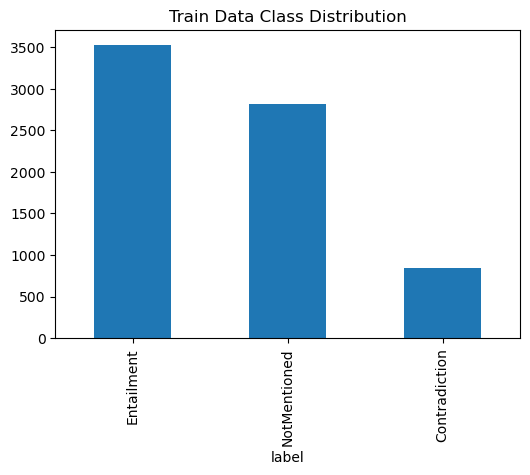

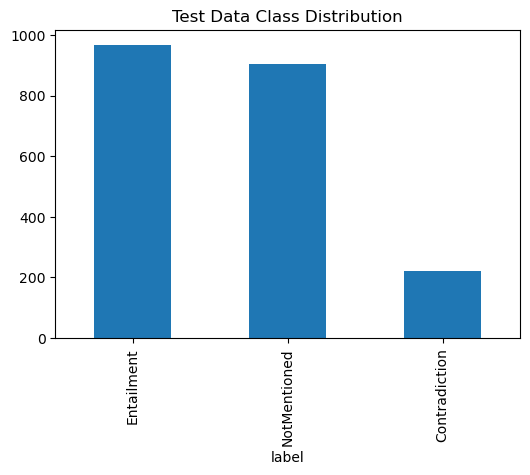

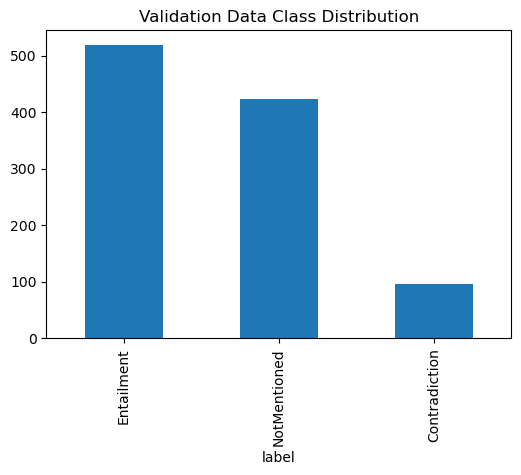

In [10]:
# Plot class distribution for each dataset
plt.figure(figsize=(6, 4))
train_df['label'].value_counts().plot(kind='bar', title='Train Data Class Distribution')
plt.show()

plt.figure(figsize=(6, 4))
test_df['label'].value_counts().plot(kind='bar', title='Test Data Class Distribution')
plt.show()

plt.figure(figsize=(6, 4))
val_df['label'].value_counts().plot(kind='bar', title='Validation Data Class Distribution')
plt.show()

#### we can observe that the dataset has a class imbalance, where:
* The "Entailment" class has the highest number of samples, followed by
* The "NotMentioned" (Neutral) class, and
* The "Contradiction" class has the fewest samples.

In [8]:
# Summary statistics for each dataset
train_summary = train_df.describe()
test_summary = test_df.describe()
val_summary = val_df.describe()

print("Train Data Summary:")
print(train_summary)

print("\nTest Data Summary:")
print(test_summary)

print("\nValidation Data Summary:")
print(val_summary)

Train Data Summary:
                                                     text   
count                                                7191  \
unique                                                423   
top     NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...   
freq                                                   17   

                                               hypothesis       label   
count                                                7191        7191  \
unique                                                 17           3   
top     Receiving Party shall not reverse engineer any...  Entailment   
freq                                                  423        3530   

       evidence_spans  
count            7191  
unique           1222  
top                []  
freq             2820  

Test Data Summary:
                                                     text   
count                                                2091  \
unique                                        

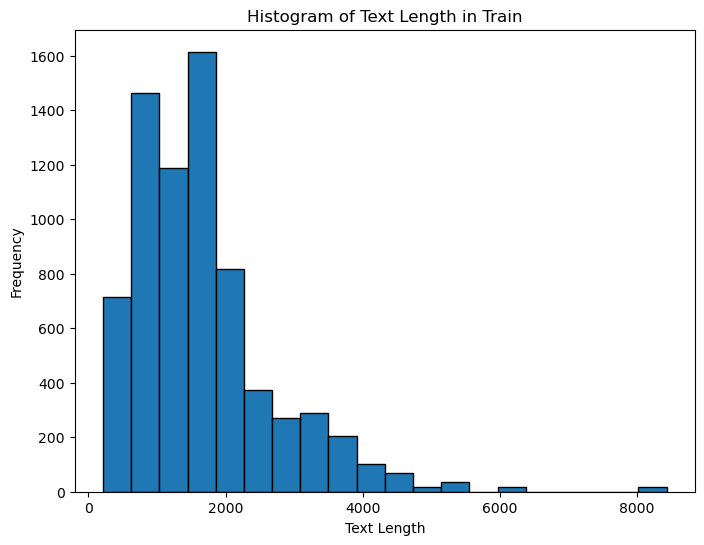

In [11]:
# Calculate the length of each text
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Create a histogram for text length
plt.figure(figsize=(8, 6))
plt.hist(train_df['text_length'], bins=20, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length in Train')
plt.show()


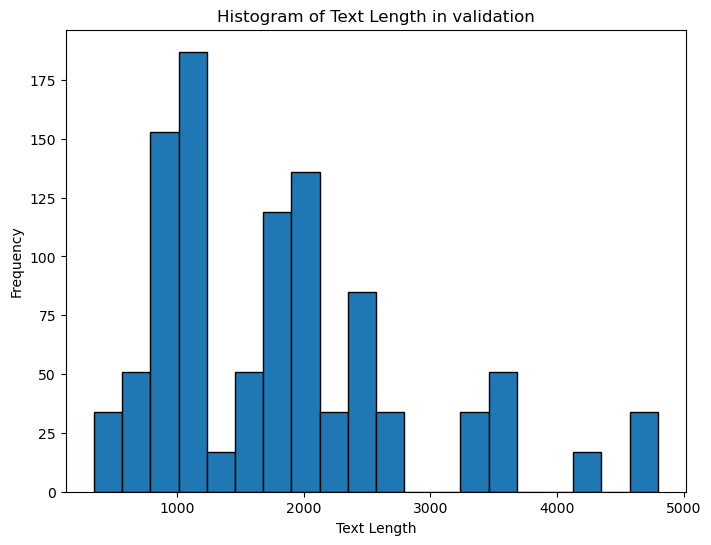

In [12]:
# Calculate the length of each text
val_df['text_length'] = val_df['text'].apply(lambda x: len(x.split()))

# Create a histogram for text length
plt.figure(figsize=(8, 6))
plt.hist(val_df['text_length'], bins=20, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length in validation')
plt.show()


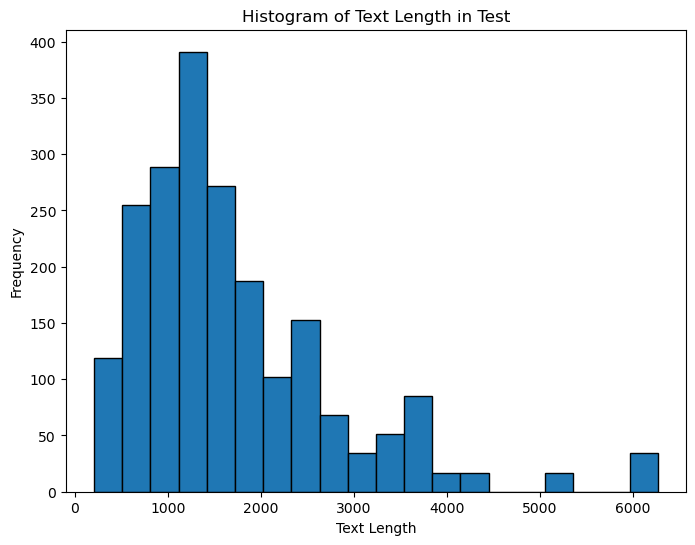

In [13]:
# Calculate the length of each text
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))

# Create a histogram for text length
plt.figure(figsize=(8, 6))
plt.hist(test_df['text_length'], bins=20, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length in Test')
plt.show()


**Report on Data Statistics and Summary**

This report presents the data statistics and summary for the training, test, and validation datasets. The dataset comprises textual data with corresponding labels, to analyze the distribution of labels and explore characteristics of the data.

**Data Label Distribution:**

The label distribution shows that the majority of the examples belong to the "Entailment" class, while the "Contradiction" class has the lowest representation.

**Data Summary:**

The data summary presents a snapshot of the textual data, hypotheses, labels, and evidence spans for each dataset.

**Train Data Summary:**
- Total Examples: 7191
- Unique Texts: 423
- Unique Hypotheses: 17
- Top Hypothesis: "Receiving Party shall not reverse engineer any..."
- Top Label: Entailment
- Top Evidence Span Frequency: 2820 (out of 7191 examples)

**Test Data Summary:**
- Total Examples: 2091
- Unique Texts: 122
- Unique Hypotheses: 17
- Top Hypothesis: "Receiving Party shall not reverse engineer any..."
- Top Label: Entailment
- Top Evidence Span Frequency: 903 (out of 2091 examples)

**Validation Data Summary:**
- Total Examples: 1037
- Unique Texts: 61
- Unique Hypotheses: 17
- Top Hypothesis: "Receiving Party shall not reverse engineer any..."
- Top Label: Entailment
- Top Evidence Span Frequency: 423 (out of 1037 examples)

The data summary provides insights into the diversity of textual data, the distribution of hypotheses, and the frequency of evidence spans.

**Conclusion:**

The majority of examples belong to the "Entailment" class, while "Contradiction" has the lowest representation. The data summary reveals that the most common hypothesis is related to "Receiving Party shall not reverse engineer any...".

## Q2

### Transformer Models Fine-Tunning

In [173]:
# Convert Labels to Integers
label_mapping = {'Entailment': 0, 'Contradiction': 1, 'NotMentioned': 2}
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

In [15]:
# Fine-tuning Function
def train_model(model, tokenizer, train_data, val_data, batch_size=16, epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize input data
    train_inputs = tokenizer(train_data['text'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length = 64)
    train_labels = torch.tensor(train_data['label'].tolist())

    val_inputs = tokenizer(val_data['text'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length = 64)
    val_labels = torch.tensor(val_data['label'].tolist())

    # Create DataLoader
    train_dataset = TensorDataset(train_inputs.input_ids, train_inputs.attention_mask, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(val_inputs.input_ids, val_inputs.attention_mask, val_labels)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    model.train()
    losses = []
    accs = []
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Calculate accuracy for this batch
            _, predicted_labels = torch.max(outputs.logits, dim=1)
            correct_predictions += (predicted_labels == inputs['labels']).sum().item()
            total_predictions += len(inputs['labels'])
            
        avg_loss = total_loss / len(train_dataloader)
        losses.append(avg_loss)
        accuracy = correct_predictions / total_predictions
        accs.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, Accuracy: {accuracy:.4f}")
    val_preds = eval(model , val_dataloader)
    return  model , losses, accs, val_preds


def eval(model , dataloader):
    model.eval()
    eval_preds = []
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to('cuda') for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = F.softmax(logits, dim=1)
            eval_preds.extend(preds.argmax(dim=1).tolist())
    return eval_preds

In [16]:
# Load  Models and Tokenizers

model_name_roberta = "roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name_roberta)
model_roberta = AutoModelForSequenceClassification.from_pretrained(model_name_roberta, num_labels=3)

model_name_deberta = 'microsoft/deberta-base'
tokenizer_deberta = AutoTokenizer.from_pretrained(model_name_deberta)
model_deberta = AutoModelForSequenceClassification.from_pretrained(model_name_deberta, num_labels=3)

2023-08-02 03:16:31.684656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 03:16:32.328956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'classifier.w

### On Validation Data

In [17]:
# Fine-tune Roberta Models
print("Fine-tuning RoBerta model...")
model_roberta_trained, train_roberta_losses, train_roberta_accs, val_roberta_preds = train_model(model_roberta, tokenizer_roberta, train_df, val_df)

Fine-tuning RoBerta model...
Epoch 1/3, Loss: 0.970295525126987, Accuracy: 0.5065
Epoch 2/3, Loss: 0.9443129625585344, Accuracy: 0.5508
Epoch 3/3, Loss: 0.929633177055253, Accuracy: 0.5690


In [18]:
# Evaluate Performance on Validation Data
true_labels = np.array(val_df['label'])
correct_predictions = np.sum(val_roberta_preds == true_labels)

accuracy = correct_predictions / len(true_labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 51.98%


In [21]:
print("RoBerta Model Validation Report:")
cls_roberta = classification_report(true_labels, val_roberta_preds)
print(cls_roberta)

RoBerta Model Validation Report:
              precision    recall  f1-score   support

           0       0.51      0.97      0.67       519
           1       0.00      0.00      0.00        95
           2       0.67      0.08      0.14       423

    accuracy                           0.52      1037
   macro avg       0.39      0.35      0.27      1037
weighted avg       0.53      0.52      0.39      1037



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
print("Fine-tuning DeBerta model...")
model_deberta_trained, train_deberta_losses, train_deberta_accs, val_deberta_preds = train_model(model_deberta, tokenizer_deberta, train_df, val_df)

Fine-tuning DeBerta model...
Epoch 1/3, Loss: 0.968715951707628, Accuracy: 0.4901
Epoch 2/3, Loss: 0.967939395374722, Accuracy: 0.4912
Epoch 3/3, Loss: 0.9700354125764635, Accuracy: 0.4898


In [23]:
correct_predictions_2 = np.sum(val_deberta_preds == true_labels)

accuracy_2 = correct_predictions_2 / len(true_labels) * 100
print(f"Accuracy: {accuracy_2:.2f}%")

Accuracy: 50.05%


In [24]:
print("DeBerta Model Validation Report:")
cls_deberta = classification_report(true_labels, val_deberta_preds)
print(cls_deberta)

DeBerta Model Validation Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       519
           1       0.00      0.00      0.00        95
           2       0.00      0.00      0.00       423

    accuracy                           0.50      1037
   macro avg       0.17      0.33      0.22      1037
weighted avg       0.25      0.50      0.33      1037



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> #### RoBERTa Model:

* After three epochs of fine-tuning, the RoBERTa model achieved an accuracy of 51.98% on the validation data.
* The classification report shows precision, recall, and F1-score for each class (Entailment, Contradiction, NotMentioned).
* The RoBERTa model performs well for class 0 (Entailment) with a high recall, but it struggles to correctly predict classes 1 (Contradiction) and 2 (NotMentioned).

> #### DeBERTa Model:

* After three epochs of fine-tuning, the DeBERTa model achieved an accuracy of 50.05% on the validation data.
* The classification report shows precision, recall, and F1-score for each class (Entailment, Contradiction, NotMentioned).
* The DeBERTa model performs similarly to random guessing (accuracy ~ 33%) for classes 1 (Contradiction) and 2 (NotMentioned), resulting in low precision, recall, and F1-scores for these classes.

### On Test Data 

In [174]:
# Tokenize input data
test_inputs = tokenizer_roberta(test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
test_labels = torch.tensor(test_df['label'].tolist())
# Create DataLoader
test_dataset = TensorDataset(test_inputs.input_ids, test_inputs.attention_mask, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=7, shuffle=True)

# Predict using RoBERTa model
test_pred_roberta = eval(model_roberta , test_dataloader)
test_pred_roberta = np.array(test_pred_roberta)
test_df['predicted_roberta'] = test_pred_roberta 


In [175]:
# Tokenize input data
test_inputs = tokenizer_deberta(test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
test_labels = torch.tensor(test_df['label'].tolist())
# Create DataLoader
test_dataset = TensorDataset(test_inputs.input_ids, test_inputs.attention_mask, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=7, shuffle=True)

# Predict using DeBERTa model
test_pred_deberta  = eval(model_deberta , test_dataloader)
test_pred_deberta = np.array(test_pred_deberta)
test_df['predicted_deberta'] = test_pred_deberta 


In [197]:
# Evaluate Performance on test Data
true_labels = np.array(test_df['label'])
correct_predictions_1_test = np.sum(test_pred_roberta == true_labels)

accuracy_test_1 = correct_predictions_1_test / len(true_labels) * 100
print(f"Accuracy: {accuracy_test_1:.2f}%")

Accuracy: 43.95%


In [198]:
print("RoBerta Model Test Report:")
cls_roberta_test_1 = classification_report(true_labels, test_pred_roberta)
print(cls_roberta_test_1)

RoBerta Model Test Report:
              precision    recall  f1-score   support

           0       0.44      0.27      0.34       968
           1       0.00      0.00      0.00       220
           2       0.44      0.73      0.55       903

    accuracy                           0.44      2091
   macro avg       0.29      0.33      0.29      2091
weighted avg       0.39      0.44      0.39      2091



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [194]:
# Evaluate Performance on test Data
true_labels = np.array(test_df['label'])
correct_predictions_2_test = np.sum(test_pred_deberta == true_labels)

accuracy_test_2 = correct_predictions_2_test / len(true_labels) * 100
print(f"Accuracy: {accuracy_test_2:.2f}%")

Accuracy: 46.29%


In [199]:
print("DeBerta Model Test Report:")
cls_roberta_test_2 = classification_report(true_labels, test_pred_deberta)
print(cls_roberta_test_2)

RoBerta Model Test Report:
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       968
           1       0.00      0.00      0.00       220
           2       0.00      0.00      0.00       903

    accuracy                           0.46      2091
   macro avg       0.15      0.33      0.21      2091
weighted avg       0.21      0.46      0.29      2091



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


> #### RoBERTa Model:
* The RoBERTa model achieved an accuracy of 44% on the test data
* The RoBERTa model exhibits similar patterns as the DeBERTa model. 
* It has a higher precision for the "Entailment" class compared to DeBERTa, but its recall is lower, indicating that it predicts fewer "Entailment" examples correctly. 
* For the "Contradiction" class, the RoBERTa model shows better recall than DeBERTa, but the precision remains low.
* Similar to DeBERTa, the RoBERTa model struggles to predict the "NotMentioned" class correctly, resulting in a precision, recall, and F1-score of 0.

> #### DeBERTa Model :

* The DeBERTa model achieved an accuracy of 46% on the test data. 
* The DeBERTa model shows relatively good precision and recall for the "Entailment" class, with a high recall of 1.00 indicating that it correctly predicted most of the "Entailment" examples. 
* However, the model performs poorly for classes "NotMentioned" and "Contradiction" with very low precision, recall, and F1-scores, indicating that it struggles to correctly predict examples from these classes.


> #### Comparison:

In comparison, the DeBERTa model outperforms the RoBERTa model in terms of overall accuracy. However, both models face challenges in predicting the "NotMentioned" and "Contradiction" classes, as indicated by their low precision, recall, and F1-scores for these classes. Additionally, it is essential to consider the class distribution and data quality when interpreting the results. The models' limitations and strengths should be considered when selecting the most suitable model for the intended application. Further fine-tuning or model architecture modifications may be necessary to improve the models' overall performance on the test data.

In [176]:
test_df.to_csv("yarab.csv" , index =  False)

In [177]:
test_df

,text,hypothesis,label,evidence_spans,predicted_roberta,predicted_deberta
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,2,[],2,0
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,0,"[84, 85, 86]",2,0
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,0,[45],0,0
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,2,[],2,0
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,1,"[25, 32]",0,0
...,...,...,...,...,...,...
2086,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may create a copy of some Conf...,2,[],0,0
2087,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party shall notify Disclosing Party ...,0,[32],2,0
2088,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may acquire information simila...,0,"[15, 19]",2,0
2089,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may share some Confidential In...,0,"[14, 30]",0,0


## Q3

### Error Analysis

In [178]:
error_analysis_df = pd.read_csv("yarab.csv" )

error_analysis_df['text_length'] = error_analysis_df['text'].apply(lambda x: len(x.split()))
error_analysis_df['hypothesis_length'] = error_analysis_df['hypothesis'].apply(lambda x: len(x.split()))

# Select The incorrect values in the error_analysis_df dataframe 
error_deberta = error_analysis_df[error_analysis_df['label'] != error_analysis_df['predicted_deberta']]
error_roberta = error_analysis_df[error_analysis_df['label'] != error_analysis_df['predicted_roberta']]

In [179]:
error_analysis_df 

,text,hypothesis,label,evidence_spans,predicted_roberta,predicted_deberta,text_length,hypothesis_length
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,2,[],2,0,2454,14
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,0,"[84, 85, 86]",2,0,2454,14
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,0,[45],0,0,2454,11
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,2,[],2,0,2454,13
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,1,"[25, 32]",0,0,2454,7
...,...,...,...,...,...,...,...,...
2086,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may create a copy of some Conf...,2,[],0,0,3420,13
2087,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party shall notify Disclosing Party ...,0,[32],2,0,3420,23
2088,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may acquire information simila...,0,"[15, 19]",2,0,3420,13
2089,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may share some Confidential In...,0,"[14, 30]",0,0,3420,13


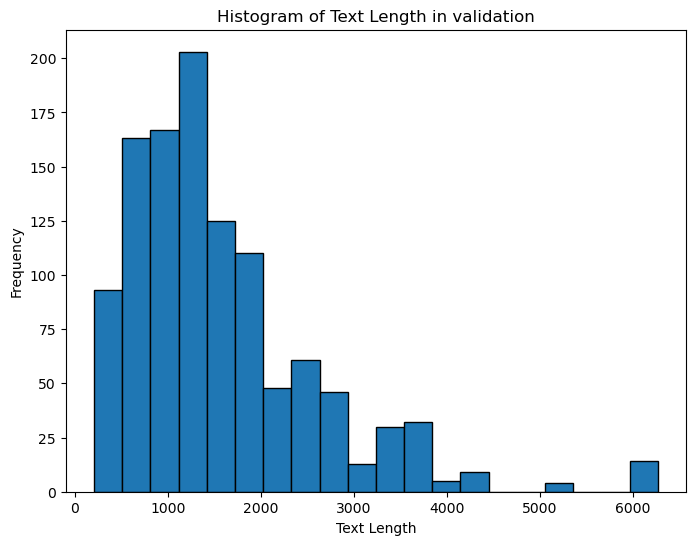

In [180]:

# Create a histogram for text length
plt.figure(figsize=(8, 6))
plt.hist(error_deberta['text_length'], bins=20, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length in validation')
plt.show()

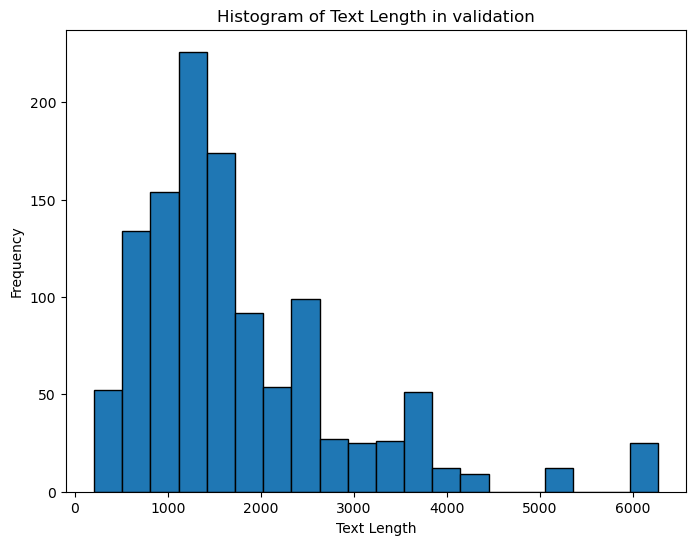

In [181]:

# Create a histogram for text length
plt.figure(figsize=(8, 6))
plt.hist(error_roberta['text_length'], bins=20, edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length in validation')
plt.show()

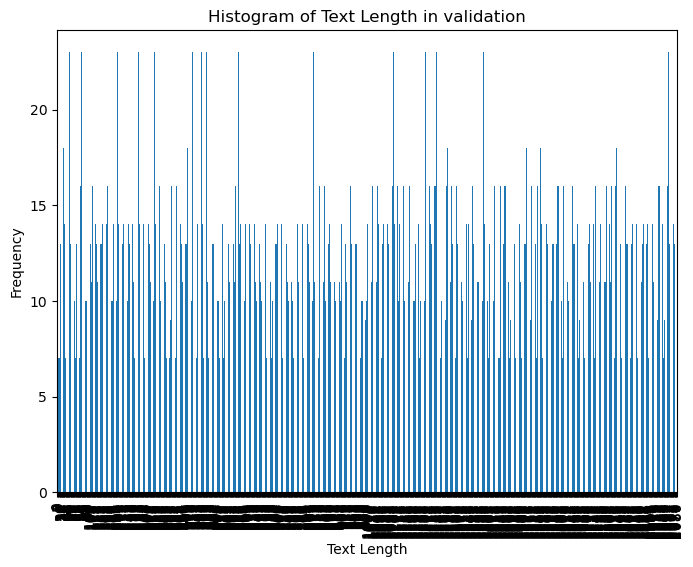

In [185]:
# Create a histogram for text length
plt.figure(figsize=(8, 6))
#(error_deberta['hypothesis_length'], bins=20, edgecolor='black')
error_deberta['hypothesis_length'].plot(kind = 'hi')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length in validation')
plt.show()

Confusion Matrix:
 [[264   0 704]
 [ 83   0 137]
 [248   0 655]]


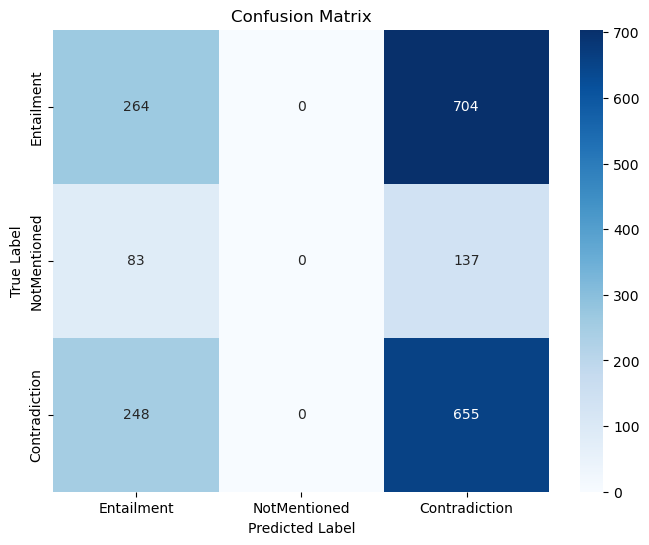

In [186]:
# Generate confusion matrix
confusion_matrix_arr = confusion_matrix(test_df['label'], test_df['predicted_roberta'])
print("Confusion Matrix:\n", confusion_matrix_arr)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_arr, annot=True, fmt='d', cmap='Blues', xticklabels=['Entailment', 'NotMentioned', 'Contradiction'], yticklabels=['Entailment', 'NotMentioned', 'Contradiction'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:
 [[968   0   0]
 [220   0   0]
 [903   0   0]]


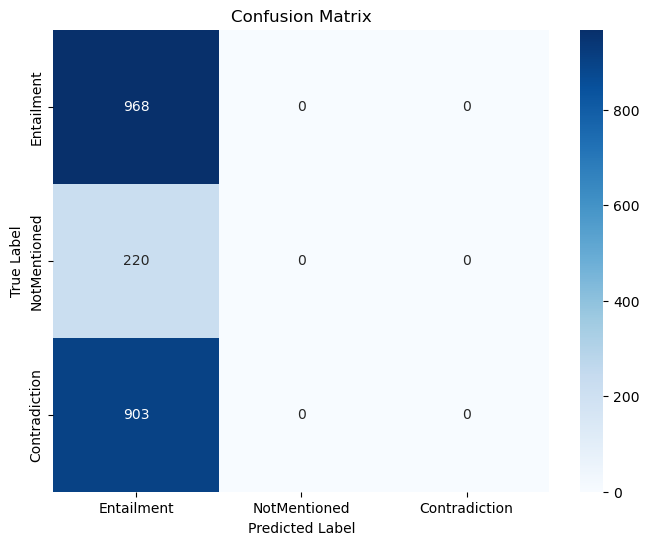

In [187]:
# Generate confusion matrix
confusion_matrix_arr = confusion_matrix(test_df['label'], test_df['predicted_deberta'])
print("Confusion Matrix:\n", confusion_matrix_arr)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_arr, annot=True, fmt='d', cmap='Blues', xticklabels=['Entailment', 'NotMentioned', 'Contradiction'], yticklabels=['Entailment', 'NotMentioned', 'Contradiction'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [188]:
# Error Examples
print("Deberta Error Examples:")
print(error_deberta[['text', 'hypothesis', 'label', f'predicted_{"DeBERTa".lower()}']])


Deberta Error Examples:
                                                   text   
0     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...  \
3     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
4     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
5     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
9     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
...                                                 ...   
2077  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2078  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2079  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2084  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2086  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   

                                             hypothesis  label   
0     Receiving Party shall not reverse engineer any...      2  \
3     Receiving Party shall not disclose the fact th...      2   
4     Confidential Information shall only include te...      1   
5  

In [189]:
# Error Examples
print("RoBERTa Error Examples:")
print(error_roberta[['text', 'hypothesis', 'label', f'predicted_{"RoBERTa".lower()}']])


RoBERTa Error Examples:
                                                   text   
1     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...  \
4     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
5     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
6     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
7     NON-DISCLOSURE AGREEMENT\nRequired under JEA's...   
...                                                 ...   
2085  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2086  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2087  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2088  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   
2090  EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...   

                                             hypothesis  label   
1     Receiving Party shall destroy or return some C...      0  \
4     Confidential Information shall only include te...      1   
5     All Confidential Information shall be expressl...      1   
6  

Class-wise Analysis for RoBERTa:


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.45      0.20      0.28       968
           1       0.00      0.00      0.00       220
           2       0.43      0.78      0.55       903

    accuracy                           0.43      2091
   macro avg       0.29      0.33      0.28      2091
weighted avg       0.39      0.43      0.37      2091

Class-wise Analysis for DeBERTa:


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.46      1.00      0.63       968
           1       0.00      0.00      0.00       220
           2       0.00      0.00      0.00       903

    accuracy                           0.46      2091
   macro avg       0.15      0.33      0.21      2091
weighted avg       0.21      0.46      0.29      2091



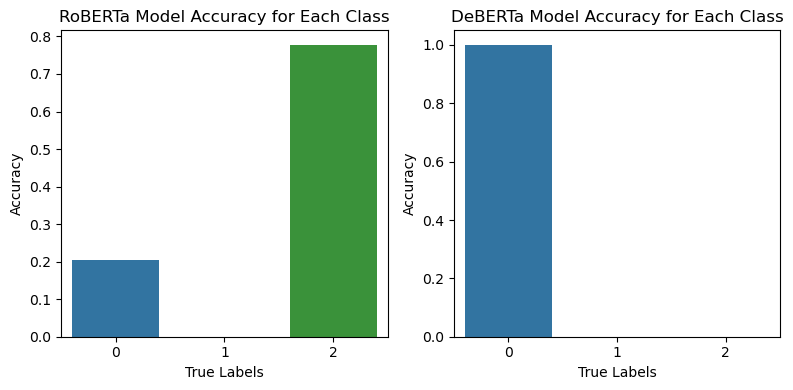

In [170]:
from sklearn.metrics import classification_report

# Class-wise Analysis for RoBERTa
print("Class-wise Analysis for RoBERTa:")
cls_report_roberta = classification_report(error_analysis_df['label'], error_analysis_df['predicted_roberta'])
print(cls_report_roberta)

# Class-wise Analysis for DeBERTa
print("Class-wise Analysis for DeBERTa:")
cls_report_deberta = classification_report(error_analysis_df['label'], error_analysis_df['predicted_deberta'])
print(cls_report_deberta)

# Plot accuracy for each class
class_accuracy_roberta = error_analysis_df.groupby('label').apply(lambda x: (x['label'] == x['predicted_roberta']).mean())
class_accuracy_deberta = error_analysis_df.groupby('label').apply(lambda x: (x['label'] == x['predicted_deberta']).mean())

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=class_accuracy_roberta.index, y=class_accuracy_roberta.values)
plt.xlabel("True Labels")
plt.ylabel("Accuracy")
plt.title("RoBERTa Model Accuracy for Each Class")

plt.subplot(1, 2, 2)
sns.barplot(x=class_accuracy_deberta.index, y=class_accuracy_deberta.values)
plt.xlabel("True Labels")
plt.ylabel("Accuracy")
plt.title("DeBERTa Model Accuracy for Each Class")

plt.tight_layout()
plt.show()


> ### The class-wise analysis reveals that: 
* both models show limitations in correctly predicting classes 1 and 2.
* DeBERTa demonstrates superior recall for class 0 (precision 0.46, recall 1.00) compared to RoBERTa (precision 0.45, recall 0.20).
* However, it is important to note that both models have low precision, recall, and F1-score for class 1 and class 2.

Overall, DeBERTa exhibits a marginally higher accuracy (46%) compared to RoBERTa (43%), but both models face challenges in predicting certain classes accurately.

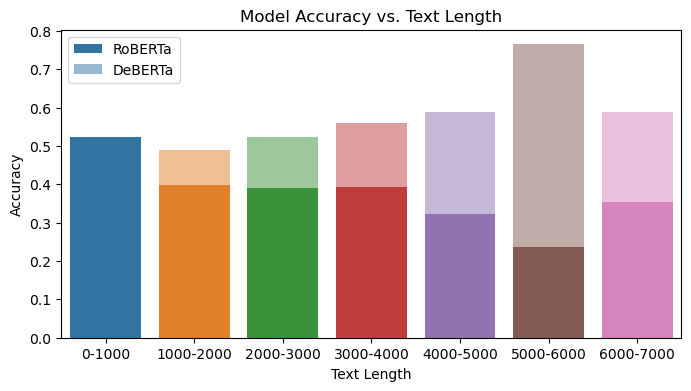

In [166]:
# Length-based Analysis for RoBERTa
# Create bins for text lengths
bins = [0, 1000, 2000, 3000 , 4000, 5000, 6000, float('inf')]
labels = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-7000']

# Group data based on text lengths for both models
error_analysis_df['text_length_bin'] = pd.cut(error_analysis_df['text_length'], bins=bins, labels=labels)

length_analysis_roberta = error_analysis_df.groupby('text_length_bin').apply(lambda x: (x['label'] == x['predicted_roberta']).mean())
length_analysis_deberta = error_analysis_df.groupby('text_length_bin').apply(lambda x: (x['label'] == x['predicted_deberta']).mean())

# Plot accuracy vs. text lengths for both models
plt.figure(figsize=(8, 4))
sns.barplot(x=length_analysis_roberta.index, y=length_analysis_roberta.values, label='RoBERTa')
sns.barplot(x=length_analysis_deberta.index, y=length_analysis_deberta.values, label='DeBERTa', alpha = 0.5)
plt.xlabel("Text Length")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Text Length")
plt.legend()
plt.show()

* The RoBERTa performs better than DeBERTa when the text length was in the range of 0-1000
* But over all DeBERTa outperforms performs RoBERTa
* The observed difference in performance between RoBERTa and DeBERTa for different text lengths suggests that they might have distinct capabilities in handling text of varying lengths. RoBERTa might be better suited for shorter text sequences (0-1000 tokens) due to its architecture and pre-training strategies, while DeBERTa might excel in longer text sequences.

In [193]:
# Initialize lists to store misclassified samples
misclassified_samples = []
roberta_misclassifications = []
deberta_misclassifications = []

# Iterate through the test dataset
for index, row in test_df.iterrows():
    if row['label'] != row['predicted_roberta'] or row['label'] != row['predicted_deberta']:
        # Store the misclassified sample along with true and predicted labels
        misclassified_samples.append(row['text'])
        roberta_misclassifications.append(row['predicted_roberta'])
        deberta_misclassifications.append(row['predicted_deberta'])

# Compare the misclassifications between RoBERTa and DeBERTa
for i in range(len(misclassified_samples)):
    if roberta_misclassifications[i] != deberta_misclassifications[i]:
        print("Sample:", misclassified_samples[i])
        print("True Label:", test_df.iloc[i]['label'])
        print("RoBERTa Prediction:", roberta_misclassifications[i])
        print("DeBERTa Prediction:", deberta_misclassifications[i])
        print("---------------------------------------------------")

# Calculate and compare performance metrics on the misclassified samples
roberta_mis_accuracy = sum([1 for i in range(len(misclassified_samples)) if roberta_misclassifications[i] == test_df.iloc[i]['label']]) / len(misclassified_samples)
deberta_mis_accuracy = sum([1 for i in range(len(misclassified_samples)) if deberta_misclassifications[i] == test_df.iloc[i]['label']]) / len(misclassified_samples)

print("RoBERTa Misclassification Accuracy:", roberta_mis_accuracy)
print("DeBERTa Misclassification Accuracy:", deberta_mis_accuracy)


Sample: NON-DISCLOSURE AGREEMENT
Required under JEA's Confidential Information Protection Program
THIS NON-DISCLOSURE AGREEMENT ("Agreement") is entered into this ______day of
__________ by and between JEA, located at 21 West Church Street, Jacksonville, Florida 32202 (the "Discloser"), and ____________________________________________________________ with an address at ______________________________________________ (the "Recipient") (hereafter Discloser and Recipient shall be referred to as the PARTIES}.
WHEREAS, the Recipient desires to work with the discloser and/or view ______________________________________________________________________documents regarding ____________________________________ (the "Transaction"); and
WHEREAS, the discloser is required by its internal policies, state and federal laws, rules, regulations or standards to ensure that sensitive and confidential information is protected and not disclosed to the public;
WHEREAS, the Parties have entered into a transactio

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



RoBERTa Misclassification Accuracy: 0.4428024083196497
DeBERTa Misclassification Accuracy: 0.4466338259441708


### Q3
> The methodlogy I followed was :
1. I identified Misclassified Samples: Create two dataframes error_deberta and error_roberta to store the misclassified samples for DeBERTa and RoBERTa.
2. I plotted s histogram of Text Length  to visualize the distribution of text lengths for misclassified samples in both DeBERTa and RoBERTa. The histograms will help identify any patterns related to text length and its impact on model performance.
3. I generated confusion matrices for both DeBERTa and RoBERTa models to provide a detailed view of the model's performance for each class and help identify which classes are prone to misclassification.
4. I Printed the error examples for both models. it may will show the misclassified text, hypothesis, true label, and predicted label for each model. Examining these examples may provide insights into the types of errors made by each model.
5. I performed a Class-wise Analysis and Calculated precision, recall, F1-score, and accuracy for each class using the classification_report function. it will give a detailed understanding of how well each model performs for different classes and identify classes where the model struggles to make correct predictions.
6. I performed  an accuracy comparison to plot the accuracy for each class using bar plots to compare the performance of DeBERTa and RoBERTa to allow for a quick comparison of the accuracy achieved by each model for each class.
7. I performed a length-based analysis by creating bins for text lengths and grouping the data based on these bins. Calculate the accuracy for each bin to observe if there are any trends related to text length and model performance.

Q4 :

> both models are struggling to perform well , as indicated by low accuracies and F1-scores for certain classes. Possible reasons for the lower performance could include:

* Lack of Data: The models may not have been exposed to sufficient labeled examples for certain classes, leading to poor generalization.

* Class Imbalance: If some classes are underrepresented in the training data, the models may have difficulty learning to distinguish them effectively.

* Fine-tuning Parameters: The number of fine-tuning epochs and the learning rate might need further tuning to achieve better results.

> To improve the performance:

* Increasing the amount of training data, especially for classes with lower support.
* Fine-tuning the models with different hyperparameters or longer training epochs.
* Experimenting with other transformer models or architectures.
* Handling the class imbalance by sampling techniques.